# SARIMAX and ARIMA forecasters

SARIMAX (Seasonal Autoregressive Integrated Moving-Average with Exogenous Regressors) is a generalization of the ARIMA model that incorporates both seasonality and exogenous variables. SARIMAX models are among the most widely used statistical forecasting models with excellent forecasting performance.

In the SARIMAX model notation, the parameters $p$, $d$, and $q$ represent the autoregressive, differencing, and moving-average components, respectively. $P$, $D$, and $Q$ denote the same components for the seasonal part of the model, with $m$ representing the number of periods in each season.

+ $p$ is the order (number of time lags) of the autoregressive part of the model.

+ $d$ is the degree of differencing (the number of times that past values have been subtracted from the data).

+ $q$ is the order of the moving-average part of the model.

+ $P$ is the order (number of time lags) of the seasonal part of the model

+ $D$ is the degree of differencing (the number of times the data have had past values subtracted) of the seasonal part of the model.

+ $Q$ is the order of the moving-average of the seasonal part of the model.

+ $m$ refers to the number of periods in each season.

When two out of the three terms are zeros, the model may be referred to based on the non-zero parameter, dropping "AR", "I" or "MA" from the acronym describing the model. For example, $ARIMA(1,0,0)$ is $AR(1)$, $ARIMA(0,1,0)$ is $I(1)$, and $ARIMA(0,0,1)$ is $MA(1)$.

The  `ForecasterSarimax` class allows for training and validating SARIMAX models from [pmdarima](http://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.ARIMA.html#pmdarima.arima.ARIMA) (internally wraps the [statsmodels SARIMAX](https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html)) using the skforecast API. This facilitates the comparison of its performance with other machine learning models.


## Libraries

In [1]:
# Libraries
# ======================================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skforecast.ForecasterSarimax import ForecasterSarimax
from skforecast.model_selection_sarimax import backtesting_sarimax
from skforecast.model_selection_sarimax import grid_search_sarimax
from pmdarima import ARIMA
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

## Data

Train dates : 1991-07-01 00:00:00 --- 2005-06-01 00:00:00  (n=168)
Test dates  : 2005-07-01 00:00:00 --- 2008-06-01 00:00:00  (n=36)


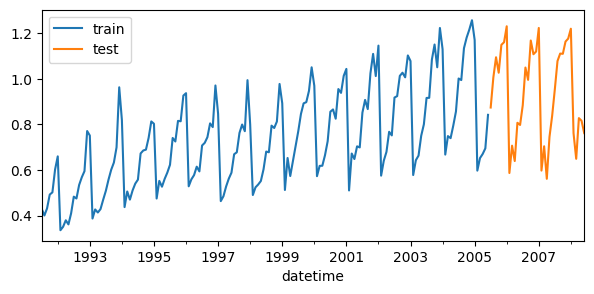

In [2]:
# Download data
# ======================================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o.csv')
data = pd.read_csv(url, sep=',', header=0, names=['y', 'datetime'])

# Data preprocessing
# ======================================================================================
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y-%m-%d')
data = data.set_index('datetime')
data = data.asfreq('MS')
data = data['y']
data = data.sort_index()

# Train-test dates
# ======================================================================================
end_train = '2005-06-01 23:59:00'
print(f"Train dates : {data.index.min()} --- {data.loc[:end_train].index.max()}  (n={len(data.loc[:end_train])})")
print(f"Test dates  : {data.loc[end_train:].index.min()} --- {data.loc[:].index.max()}  (n={len(data.loc[end_train:])})")
data_train = data.loc[:end_train]
data_test  = data.loc[end_train:]

# Plot
# ======================================================================================
fig, ax=plt.subplots(figsize=(7, 3))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
ax.legend();

## ForecasterSarimax

## Training

In [3]:
# Create and fit ForecasterSarimax
# ======================================================================================
forecaster = ForecasterSarimax(
                 regressor=ARIMA(order=(12, 1, 1), seasonal_order=(0, 0, 0, 0), maxiter=200),
             )

forecaster.fit(y=data_train)
forecaster

ForecasterSarimax 
Regressor:  ARIMA(12,1,1)(0,0,0)[0] intercept 
Regressor parameters: {'maxiter': 200, 'method': 'lbfgs', 'order': (12, 1, 1), 'out_of_sample_size': 0, 'scoring': 'mse', 'scoring_args': None, 'seasonal_order': (0, 0, 0, 0), 'start_params': None, 'suppress_warnings': False, 'trend': None, 'with_intercept': True} 
fit_kwargs: {} 
Window size: 1 
Transformer for y: None 
Transformer for exog: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('1991-07-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Creation date: 2023-07-09 13:53:17 
Last fit date: 2023-07-09 13:53:24 
Index seen by the forecaster: DatetimeIndex(['1991-07-01', '1991-08-01', '1991-09-01', '1991-10-01',
               '1991-11-01', '1991-12-01', '1992-01-01', '1992-02-01',
               '1992-03-01', '1992-04-01',
               ...
               '2004-09-01', '2

## Prediction

In [4]:
# Predict
# ======================================================================================
predictions = forecaster.predict(steps=36)
predictions.head(3)

2005-07-01    0.972707
2005-08-01    0.980921
2005-09-01    1.135499
Freq: MS, Name: pred, dtype: float64

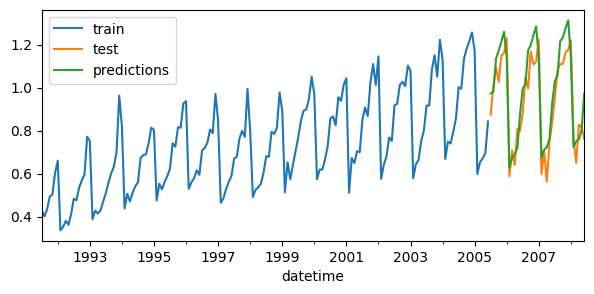

In [5]:
# Plot predictions
# ======================================================================================
fig, ax=plt.subplots(figsize=(7, 3))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [6]:
# Prediction error
# ======================================================================================
error_mse = mean_absolute_error(
                y_true = data_test,
                y_pred = predictions
            )

print(f"Test error (mse): {error_mse}")

Test error (mse): 0.08410747512369833


In [7]:
# Predict intervals
# ======================================================================================
predictions = forecaster.predict_interval(steps=36, interval=[5, 95])
predictions.head(3)

,pred,lower_bound,upper_bound
2005-07-01,0.972707,0.875165,1.070249
2005-08-01,0.980921,0.878035,1.083806
2005-09-01,1.135499,1.029322,1.241677


## Feature importances

In [8]:
forecaster.get_feature_importances()

,feature,importance
0,intercept,0.004880
1,ar.L1,-0.109625
2,ar.L2,-0.139399
3,ar.L3,-0.111263
4,ar.L4,-0.159216
5,ar.L5,-0.127676
6,ar.L6,-0.116519
7,ar.L7,-0.161350
8,ar.L8,-0.109189
9,ar.L9,-0.136153


## Backtesting

SARIMAX models can be evaluated using any of the [backtesting strategies](https://skforecast.org/latest/introduction-forecasting/introduction-forecasting.html#backtesting-forecasting-models) implemented in skforecast.

In [9]:
# Backtest forecaster
# ======================================================================================
forecaster = ForecasterSarimax(
                 regressor=ARIMA(order=(12, 1, 1), seasonal_order=(0, 0, 0, 0), maxiter=200),
             )

metric, predictions = backtesting_sarimax(
                          forecaster         = forecaster,
                          y                  = data,
                          initial_train_size = len(data_train),
                          fixed_train_size   = False,
                          steps              = 12,
                          metric             = 'mean_absolute_error',
                          refit              = True,
                          n_jobs             = -1,
                          verbose            = True,
                          show_progress      = True
                      )

Information of backtesting process
----------------------------------
Number of observations used for initial training: 168
Number of observations used for backtesting: 36
    Number of folds: 3
    Number of steps per fold: 12
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   1991-07-01 00:00:00 -- 2005-06-01 00:00:00  (n=168)
    Validation: 2005-07-01 00:00:00 -- 2006-06-01 00:00:00  (n=12)
Fold: 1
    Training:   1991-07-01 00:00:00 -- 2006-06-01 00:00:00  (n=180)
    Validation: 2006-07-01 00:00:00 -- 2007-06-01 00:00:00  (n=12)
Fold: 2
    Training:   1991-07-01 00:00:00 -- 2007-06-01 00:00:00  (n=192)
    Validation: 2007-07-01 00:00:00 -- 2008-06-01 00:00:00  (n=12)



  0%|          | 0/3 [00:00<?, ?it/s]

/home/ubuntu/anaconda3/envs/skforecast_09_py11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ubuntu/anaconda3/envs/skforecast_09_py11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ubuntu/anaconda3/envs/skforecast_09_py11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [10]:
print(f"Error backtest: {metric}")

Error backtest: 0.06965763353219342


In [11]:
predictions.head(4)

,pred
2005-07-01,0.972707
2005-08-01,0.980921
2005-09-01,1.135499
2005-10-01,1.173184


## Model tunning

To find the optimal hyperparameters for the SARIMAX model, various [hyperparameter optimization strategies](https://skforecast.org/latest/api/model_selection_sarimax.html) can be used. It is crucial to conduct hyperparameter optimization using a validation dataset, rather than the test dataset, to ensure accurate evaluation of model performance.

Train dates      : 1991-07-01 00:00:00 --- 2001-01-01 00:00:00  (n=115)
Validation dates : 2001-02-01 00:00:00 --- 2006-01-01 00:00:00  (n=60)
Test dates       : 2006-02-01 00:00:00 --- 2008-06-01 00:00:00  (n=29)


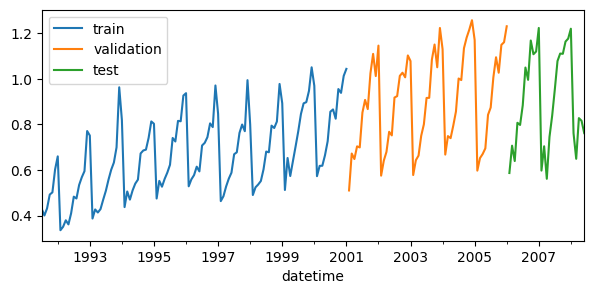

In [12]:
# Train-validation-test data
# ======================================================================================
end_train = '2001-01-01 23:59:00'
end_val = '2006-01-01 23:59:00'

print(f"Train dates      : {data.index.min()} --- {data.loc[:end_train].index.max()}  (n={len(data.loc[:end_train])})")
print(f"Validation dates : {data.loc[end_train:].index.min()} --- {data.loc[:end_val].index.max()}  (n={len(data.loc[end_train:end_val])})")
print(f"Test dates       : {data.loc[end_val:].index.min()} --- {data.index.max()}  (n={len(data.loc[end_val:])})")

# Plot
# ======================================================================================
fig, ax=plt.subplots(figsize=(7, 3))
data.loc[:end_train].plot(ax=ax, label='train')
data.loc[end_train:end_val].plot(ax=ax, label='validation')
data.loc[end_val:].plot(ax=ax, label='test')
ax.legend();

In [13]:
# Grid search hyperparameter
# ======================================================================================
forecaster = ForecasterSarimax(
                 regressor=ARIMA(order=(12, 1, 1), seasonal_order=(0, 0, 0, 0), maxiter=200),
             )

param_grid = {
    'order': [(12, 0, 0), (12, 1, 0), (12, 1, 1), (14, 1, 4)],
    'seasonal_order': [(0, 0, 0, 0)],
    'trend': [None, 'n', 'c']
}

results_grid = grid_search_sarimax(
                   forecaster         = forecaster,
                   y                  = data.loc[:end_val],
                   param_grid         = param_grid,
                   steps              = 12,
                   refit              = True,
                   metric             = 'mean_absolute_error',
                   initial_train_size = len(data_train),
                   fixed_train_size   = False,
                   return_best        = True,
                   n_jobs             = -1,
                   verbose            = False,
                   show_progress      = True
               )

results_grid.head(5)

Number of models compared: 12.


params grid:   0%|          | 0/12 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found parameters, and the whole data set: 
  Parameters: {'order': (12, 1, 1), 'seasonal_order': (0, 0, 0, 0), 'trend': 'n'}
  Backtesting metric: 0.06807733507028567



,params,mean_absolute_error,order,seasonal_order,trend
7,"{'order': (12, 1, 1), 'seasonal_order': (0, 0,...",0.068077,"(12, 1, 1)","(0, 0, 0, 0)",n
10,"{'order': (14, 1, 4), 'seasonal_order': (0, 0,...",0.072588,"(14, 1, 4)","(0, 0, 0, 0)",n
0,"{'order': (12, 0, 0), 'seasonal_order': (0, 0,...",0.075780,"(12, 0, 0)","(0, 0, 0, 0)",None
2,"{'order': (12, 0, 0), 'seasonal_order': (0, 0,...",0.075780,"(12, 0, 0)","(0, 0, 0, 0)",c
1,"{'order': (12, 0, 0), 'seasonal_order': (0, 0,...",0.076643,"(12, 0, 0)","(0, 0, 0, 0)",n


Since `return_best = True`, the forecaster object is updated with the best configuration found and trained with the whole data set. This means that the final model obtained from grid search will have the best combination of lags and hyperparameters that resulted in the highest performance metric. This final model can then be used for future predictions on new data.

In [14]:
forecaster

ForecasterSarimax 
Regressor:  ARIMA(12,1,1)(0,0,0)[0] intercept 
Regressor parameters: {'maxiter': 200, 'method': 'lbfgs', 'order': (12, 1, 1), 'out_of_sample_size': 0, 'scoring': 'mse', 'scoring_args': None, 'seasonal_order': (0, 0, 0, 0), 'start_params': None, 'suppress_warnings': False, 'trend': 'n', 'with_intercept': True} 
fit_kwargs: {} 
Window size: 1 
Transformer for y: None 
Transformer for exog: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('1991-07-01 00:00:00'), Timestamp('2006-01-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Creation date: 2023-07-09 13:53:40 
Last fit date: 2023-07-09 13:54:51 
Index seen by the forecaster: DatetimeIndex(['1991-07-01', '1991-08-01', '1991-09-01', '1991-10-01',
               '1991-11-01', '1991-12-01', '1992-01-01', '1992-02-01',
               '1992-03-01', '1992-04-01',
               ...
               '2005-04-01', '20

In [15]:
%%html
<style>
.jupyter-wrapper .jp-CodeCell .jp-Cell-inputWrapper .jp-InputPrompt {display: none;}
</style>